In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import the required libraries

In [35]:
import pandas as pd
import numpy as np
import keras
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Read the Data

In [54]:
df_train=pd.read_csv('../input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv')
df_val=pd.read_csv('../input/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv')
df_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [55]:
df_val.head()

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


In [56]:
X_train=df_train['text'].values
Y_train=df_train['label'].values

In [57]:
X_val=df_val['text'].values
Y_val=df_val['label'].values

In [60]:
(X_train.shape,Y_train.shape),(X_val.shape,Y_val.shape)

(((40000,), (40000,)), ((5000,), (5000,)))

# Analyse the Data

In [64]:
df_train.iloc[:,1].describe()

count    40000.000000
mean         0.499525
std          0.500006
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [65]:
df_val.iloc[:,1].describe()

count    5000.000000
mean        0.502800
std         0.500042
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [79]:
df1=pd.DataFrame(X_val_len,columns=['len'])
df1.describe()

,len
count,5000.00000
mean,228.93260
std,169.33721
min,10.00000
25%,126.00000
50%,171.00000
75%,274.00000
max,1601.00000


In [75]:
df=pd.DataFrame(X_train_len,columns=['len'])
df.describe()

,len
count,40000.000000
mean,231.339250
std,171.194123
min,4.000000
25%,126.000000
50%,173.000000
75%,282.000000
max,2470.000000


(array([2.8097e+04, 8.6960e+03, 2.2520e+03, 8.0100e+02, 1.3800e+02,
        7.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([   4. ,  250.6,  497.2,  743.8,  990.4, 1237. , 1483.6, 1730.2,
        1976.8, 2223.4, 2470. ]),
 <a list of 10 Patch objects>)

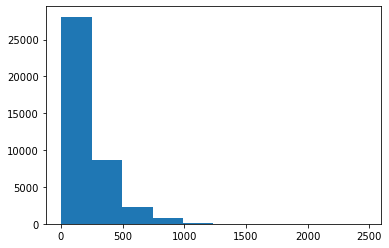

In [73]:
X_train_len=[len(str(i).split()) for i in X_train]
plt.hist(X_train_len)

(array([2.470e+03, 1.602e+03, 5.350e+02, 1.970e+02, 1.180e+02, 5.100e+01,
        2.300e+01, 1.000e+00, 2.000e+00, 1.000e+00]),
 array([  10. ,  169.1,  328.2,  487.3,  646.4,  805.5,  964.6, 1123.7,
        1282.8, 1441.9, 1601. ]),
 <a list of 10 Patch objects>)

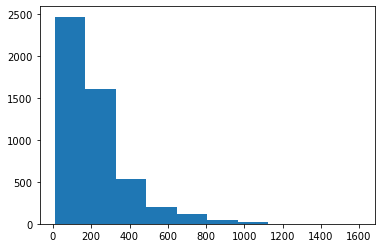

In [77]:
X_val_len=[len(str(i).split()) for i in X_val]
plt.hist(X_val_len)

# Setting the parameters

In [6]:
vocab_size=30000 #went for an average vocab size 
embedding_dimension=64 #high dimensions would result in finding better parameters for similarity 
max_length=120 #used a maximum length of 120 words
turnc='post'#preprocessing step for pad_sequences
oov_tok='<OOV>'#oov stands for out of vocabulary tokens

#  Tokenizing  and converting the data into Sequences

In [7]:
tokenizer=Tokenizer(num_words=vocab_size,filters='''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~¡¢£¤¦§¨«­®°³´·º»½¾¿ßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþğıōżאגויכלמןר–‘’“”…″₤★、''',oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
X=tokenizer.texts_to_sequences(X_train)
X_padded=pad_sequences(X,maxlen=max_length,padding='post',truncating=turnc)
X_val_seq=tokenizer.texts_to_sequences(X_val)
X_val_padded=pad_sequences(X_val_seq,maxlen=max_length,padding='post',truncating=turnc)

In [40]:
X_padded.shape,X_val_padded.shape

((40000, 120), (5000, 120))

# The Model

In [15]:
from keras.layers import LSTM,Bidirectional,Embedding,Dense,SpatialDropout1D,Flatten,Dropout
from keras.models import Sequential

In [16]:
model=Sequential()
model.add(Embedding(vocab_size,embedding_dimension,input_length=max_length))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(120,activation='tanh',return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(120,activation='tanh',return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(300,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           1920000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 120, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 240)          177600    
_________________________________________________________________
dropout (Dropout)            (None, 120, 240)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 240)               346560    
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 300)              

In [17]:
model.compile(optimizer="rmsprop",loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
hist=model.fit(X_padded,Y_train,epochs=7,batch_size=16,validation_data=(X_val_padded,Y_val))#10 #best at 9

Epoch 1/7
2500/2500 [==============================] - 87s 35ms/step - loss: 0.4627 - accuracy: 0.7872 - val_loss: 0.3723 - val_accuracy: 0.8300
Epoch 2/7
2500/2500 [==============================] - 86s 34ms/step - loss: 0.3464 - accuracy: 0.8554 - val_loss: 0.3527 - val_accuracy: 0.8410
Epoch 3/7
2500/2500 [==============================] - 88s 35ms/step - loss: 0.3176 - accuracy: 0.8709 - val_loss: 0.3672 - val_accuracy: 0.8610
Epoch 4/7
2500/2500 [==============================] - 86s 34ms/step - loss: 0.2968 - accuracy: 0.8804 - val_loss: 0.3437 - val_accuracy: 0.8620
Epoch 5/7
2500/2500 [==============================] - 87s 35ms/step - loss: 0.2803 - accuracy: 0.8894 - val_loss: 0.3453 - val_accuracy: 0.8596
Epoch 6/7
2500/2500 [==============================] - 90s 36ms/step - loss: 0.2656 - accuracy: 0.8959 - val_loss: 0.3149 - val_accuracy: 0.8706
Epoch 7/7
2500/2500 [==============================] - 88s 35ms/step - loss: 0.2546 - accuracy: 0.9023 - val_loss: 0.3263 - val_ac

In [26]:
hist=model.fit(X_padded,Y_train,epochs=2,batch_size=16,validation_data=(X_val_padded,Y_val))#10 #best at 9

Epoch 1/2
2500/2500 [==============================] - 87s 35ms/step - loss: 0.2417 - accuracy: 0.9110 - val_loss: 0.3160 - val_accuracy: 0.8716
Epoch 2/2
2500/2500 [==============================] - 86s 34ms/step - loss: 0.2358 - accuracy: 0.9151 - val_loss: 0.3547 - val_accuracy: 0.8732


# This Plot is for the last two Epochs

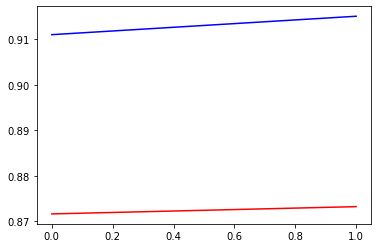

In [38]:
plt.plot(hist.history['accuracy'],c='b')
plt.plot(hist.history['val_accuracy'],c='r')
plt.show()

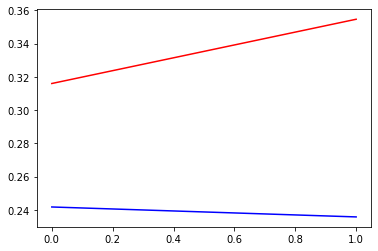

In [39]:
plt.plot(hist.history['loss'],c='b')
plt.plot(hist.history['val_loss'],c='r')
plt.show()

# Reading the Test Data

In [19]:
df_test=pd.read_csv('../input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv')
df_test

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0
...,...,...
4995,This is the kind of picture John Lassiter woul...,1
4996,A MUST SEE! I saw WHIPPED at a press screening...,1
4997,NBC should be ashamed. I wouldn't allow my chi...,0
4998,This movie is a clumsy mishmash of various gho...,0


In [20]:
X_test=df_test['text'].values
Y_test=df_test['label'].values

# Converting into Sequential Data

In [21]:
X_test_seq=tokenizer.texts_to_sequences(X_test)

In [22]:
X_test_padded=pad_sequences(X_test_seq,maxlen=max_length,padding='post',truncating=turnc)
X_test_padded[0]

array([   11,   212,  1082,    12,   200,   125,    16,   112,     4,
         570,  7688,  3306,    86,  1242,  5463,    15,   565,    10,
           9,     3,  2713,    20,    93,    30,   255,     4,  1650,
       16887,  4040,   102,     4,   450,  8685,   459,  1004,    11,
        1679,    13,     2,  2894,    15,    32,     2,    97,    24,
           2,    79,   490,     5,     2,   677,   831,   149,    11,
          98,    29,    43,  1916,    57,     3,  2247,   621,     2,
         677,     6,    76,     2,  2894,    42,    60,     6,     2,
         240,     6,   480,     2,  1190,    20,    93,   136,    25,
          43,    76,    57,     3,  1194,   621,     2,   649,     6,
         105,   240,    10,   165,  1051,  4891,     6,    13,    11,
         307,    38,    11,   861,     6,    43,  2988,  2503,    24,
           2,  5596,     3,   191,   847,  2008,    69,    10,  1074,
          18,    70,    49], dtype=int32)

In [23]:
X_test_padded.shape

(5000, 120)

In [27]:
model.evaluate(X_test_padded,Y_test)

157/157 [==============================] - 2s 11ms/step - loss: 0.3531 - accuracy: 0.8752


[0.3531334400177002, 0.8751999735832214]

# Check for your own Reviews

In [31]:
def Check(x):
    test_case1=[x]
    test_case=tokenizer.texts_to_sequences(test_case1)
    test_case_padded=pad_sequences(test_case,padding='post',truncating=turnc)
    x=model.predict_classes(test_case_padded)
    if x==1:print("Positive", (model.predict(test_case_padded)))
    else:print("Negative", (model.predict(test_case_padded)))

In [34]:
test_review=str(input("Enter the review :  "))
Check(test_review)

Enter the review :  very bad movie
Negative [[0.00194288]]


# I just checked for one random imdb review 

In [83]:
test_review="You will get A to Z all details of this scam, i may be wrong but due to this series, i don't think that i need to watch the upcoming movie big bull because 2 to 3 hours too less for explain the story. If you are at home, just watch this web series, you will not bore for even 1 second, All actors played their role excellently, i like reporter character as w"
Check(test_review)

Positive [[0.93524843]]
